### Plots the PDFs of the extraction and the posterior

Testing the extraction of vorticity from the posterior

In [5]:
import numpy as np
import os, pickle
from scipy.sparse.linalg import eigsh
import JWS_SWOT_toolbox as swot
import matplotlib.pyplot as plt
import scipy.linalg as la
import h5py
import xarray as xr

PICKLES = "./pickles"
KARIN_NA_PATH = f"{PICKLES}/karin_NA_tmean.pkl"  # where SWOT data is held
NADIR_NA_PATH = f"{PICKLES}/nadir_NA_tmean.pkl"  # where SWOT data is held

def load(p):
    with open(p, "rb") as f:
        return pickle.load(f)

def path_nonoise(km):  # "ground truth"
    return f"{PICKLES}/balanced_extraction_synth_NA_tmean_sm_{km}km_nonoise.pkl"

def path_withnoise(km):  # extracted balanced field
    return f"{PICKLES}/balanced_extraction_synth_NA_tmean_sm_{km}km.pkl"

def finite_flat(*arrays):
    outs = []
    for a in arrays:
        v = np.asarray(a, dtype=float).ravel()
        outs.append(v[np.isfinite(v)])
    return outs

t = 40
km = 2

karin = load(KARIN_NA_PATH)
dx = float(karin.dx_km) * 1e3
dy = float(karin.dy_km) * 1e3
lat_1d = np.asarray(karin.lat)[0, :, 0]  # for gvort

ht_sim = np.asarray(load(path_nonoise(km)), dtype=float)
ht_ext = np.asarray(load(path_withnoise(km)), dtype=float)
T, ny, nx = ht_ext.shape

L_PATH = f"{PICKLES}/posterior_balanced_extraction_synth_NA_tmean_sm_{km}km.pkl"
C = load(L_PATH)
Lfac, lower = la.cho_factor(C + np.eye(C.shape[0]) * 1.0e-10, lower=True) 
Ltri = np.tril(Lfac)

# posterior sample: x ~ N(mu, C) with C ≈ L L^T
mu = (ht_ext[t] * 100).ravel()  
r = C.shape[1]
z = np.random.randn(r)  
ht_post   = (mu + Ltri @ z).reshape(ny, nx) / 100.0  # meters

post_vort = swot.compute_geostrophic_vorticity(ht_post,   dx, dy, lat_1d, order=2)
sim_vort  = swot.compute_geostrophic_vorticity(ht_sim[t], dx, dy, lat_1d, order=2)
ext_vort  = swot.compute_geostrophic_vorticity(ht_ext[t], dx, dy, lat_1d, order=2)

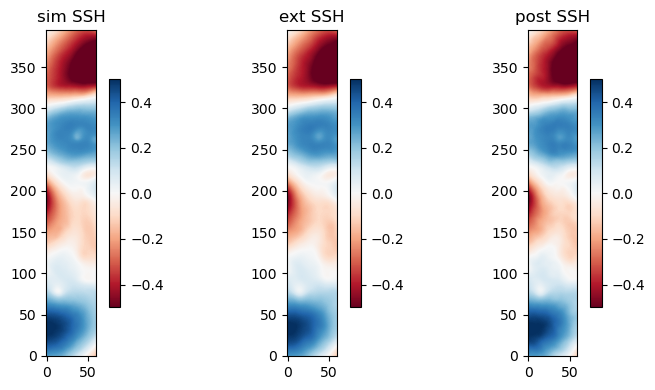

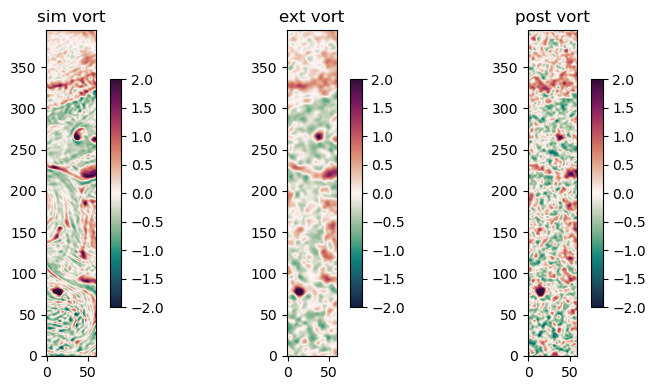

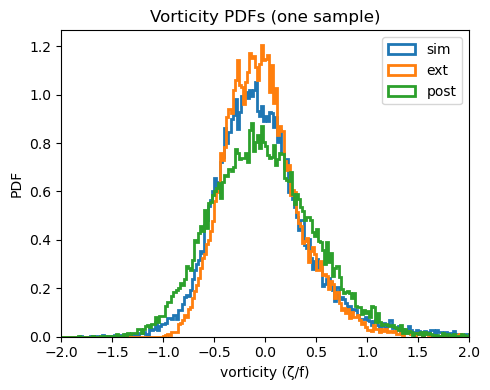

Standard deviations (relative to zero):
  sim :  0.5142
  ext :  0.4021
  post:  0.5224


In [6]:
import cmocean
fig, axes = plt.subplots(1, 3, figsize=(8,4))
fields = [ht_sim[t], ht_ext[t], ht_post]
titles = ["sim SSH", "ext SSH", f"post SSH"]

for ax, fld, ttl in zip(axes, fields, titles):
    im = ax.imshow(fld, origin="lower", cmap="RdBu", vmin = -0.5, vmax = 0.5)
    ax.set_title(ttl)
    fig.colorbar(im, ax=ax, shrink=0.7)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(8,4))
fields = [sim_vort, ext_vort, post_vort]
titles = ["sim vort", "ext vort", f"post vort"]

for ax, fld, ttl in zip(axes, fields, titles):
    im = ax.imshow(fld, origin="lower", cmap=cmocean.cm.curl, vmin = -2, vmax = 2)
    ax.set_title(ttl)
    fig.colorbar(im, ax=ax, shrink=0.7)
plt.tight_layout()
plt.show()

# Vorticity pdfs
def f(x):
    return x[np.isfinite(x)].ravel()

v_sim  = f(sim_vort)
v_ext  = f(ext_vort)
v_post = f(post_vort)

common_bins = np.linspace(-3, 3, 301)   # 300 bins between -2 and 2

plt.figure(figsize=(5,4))
plt.hist(v_sim,  bins=common_bins, histtype='step', density=True, linewidth=2, label='sim')
plt.hist(v_ext,  bins=common_bins, histtype='step', density=True, linewidth=2, label='ext')
plt.hist(v_post, bins=common_bins, histtype='step', density=True, linewidth=2, label='post')

plt.xlabel("vorticity (ζ/f)")
plt.ylabel("PDF")
plt.title("Vorticity PDFs (one sample)")
plt.xlim(-2, 2)
plt.legend()
plt.tight_layout()
plt.show()

print("Standard deviations (relative to zero):")
print(f"  sim :  {np.nanstd(v_sim):.4f}")
print(f"  ext :  {np.nanstd(v_ext):.4f}")
print(f"  post:  {np.nanstd(v_post):.4f}")

In [7]:
var_ssh_sim  = np.nanvar(ht_sim)
var_ssh_post = np.nanvar(ht_post)
var_vort_sim  = np.nanvar(sim_vort)
var_vort_post = np.nanvar(post_vort)

print("SSH variance:")
print(f"  Simulation       : {var_ssh_sim:.6e}")
print(f"  Posterior sample : {var_ssh_post:.6e}")
print()
print("Vorticity variance:")
print(f"  Simulation       : {var_vort_sim:.6e}")
print(f"  Posterior sample : {var_vort_post:.6e}")

SSH variance:
  Simulation       : 6.823004e-02
  Posterior sample : 7.549647e-02

Vorticity variance:
  Simulation       : 2.644035e-01
  Posterior sample : 2.728880e-01


#### Compute the spectra of it all 

In [8]:
def plot_spectral_fits(karin, pkarin,
                       spec0, spec1, spec2, spec3,
                       figsize=(4,4), dpi=200):

    i0 = int(karin.track_length/2)
    k  = karin.wavenumbers_cpkm[i0:]
    s0 = spec0[i0:]
    s1 = spec1[i0:]
    s2 = spec2[i0:]
    s3 = spec3[i0:]
    sim = karin.spec_alongtrack_av[i0:]

    bal = swot.balanced_model_tapered(k[1:], *pkarin[:3])
    unb = swot.unbalanced_model_tapered(k, *pkarin[3:7])
    
    fig, ax = plt.subplots(1,1, figsize=figsize, dpi=dpi)
    ax.loglog(k[1:], sim[1:],   'k', label="Simulation t averaged")
    #ax.loglog(k[1:], unb[1:],   label="Noise model")
    ax.loglog(k[1:], bal,       label="Balanced model")
    ax.loglog(k[1:], s0[1:],    label="Noiseless extraction")
    ax.loglog(k[1:], s1[1:],    label="Balanced extraction")
    ax.loglog(k[1:], s2[1:],    label="Posterior sample")
    ax.loglog(k[1:], s3[1:],    label="Simulation snapshot")
    ax.set_xlabel("Wavenumber (cpkm)")
    ax.set_ylabel("PSD (cm$^2$/cpkm)")
    ax.set_ylim(1e-5, 1e6)
    ax.legend(frameon=False, fontsize=8)

    return fig, ax

def pspec(data, window, dim, avg_dims):
    return swot.mean_power_spectrum(
        xr.DataArray(data, dims=["sample","line","pixel"], 
                     coords=[np.arange(data.shape[0]),
                             karin.y_coord_km, karin.x_coord_km]),
        window, dim, avg_dims
    )

# --- noisy KaRIn & Nadir ---
spec_ssh_noisy = pspec(karin.ssh_noisy*100, karin.window, "line", ["sample","pixel"])

# --- noisy KaRIn & Nadir ---
spec_sim = pspec(karin.ssha[t][None, :, :]*100, karin.window, "line", ["sample","pixel"])

# --- Sim smoothed ---
spec_noiseless = pspec(ht_sim[t][None, :, :]*100, karin.window, "line", ["sample","pixel"])

# --- balanced extraction ---
spec_ssh_extraction = pspec(ht_ext[t][None, :, :]*100, karin.window, "line", ["sample","pixel"])

# --- posterior sample ---
spec_ssh_post = pspec(ht_post[None, :, :]*100, karin.window, "line", ["sample","pixel"])

# Spectral model fits to the noisy data
p_karin, _   = swot.fit_spectrum(karin, spec_ssh_noisy, swot.karin_model)
k_karin      = karin.wavenumbers_cpkm[int(karin.track_length/2):]
spbalanced   = swot.balanced_model_tapered(k_karin[1:], *p_karin[0:3]) # our prior

plot_spectral_fits(
    karin,
    p_karin,
    spec_noiseless,
    spec_ssh_extraction,
    spec_ssh_post, 
    spec_sim
)

ValueError: conflicting sizes for dimension 'pixel': length 60 on the data but length 59 on coordinate 'pixel'

In [9]:
import xarray as xr

def pspec_enstrophy(vort, window, dim, avg_dims):
    vort = np.asarray(vort)
    if vort.ndim == 2:
        vort = vort[None, ...]   # add sample dim if needed

    da = xr.DataArray(
        vort,
        dims=["sample", "line", "pixel"],
        coords=[
            np.arange(vort.shape[0]),
            karin.y_coord_km,
            karin.x_coord_km
        ]
    )
    spec = swot.mean_power_spectrum(da, window, dim, avg_dims)
    return spec

sim_vort_inst  = swot.compute_geostrophic_vorticity(karin.ssha[t], dx, dy, lat_1d, order=4)

spec_enst_sim  = pspec_enstrophy(sim_vort,  karin.window, "line", ["sample", "pixel"])
spec_enst_ext  = pspec_enstrophy(ext_vort,  karin.window, "line", ["sample", "pixel"])
spec_enst_post = pspec_enstrophy(post_vort, karin.window, "line", ["sample", "pixel"])
spec_sim_inst = pspec_enstrophy(sim_vort_inst, karin.window, "line", ["sample", "pixel"])

def plot_enstrophy_spectra(karin,
                           spec_sim,
                           spec_ext,
                           spec_post,
                           spec_sim_inst,
                           figsize=(4,4), dpi=200):

    i0 = int(karin.track_length / 2)
    k   = karin.wavenumbers_cpkm[i0:]
    s_s = spec_sim[i0:]
    s_e = spec_ext[i0:]
    s_p = spec_post[i0:]
    s_i = spec_sim_inst[i0:]

    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    ax.loglog(k[1:], s_s[1:], 'k', label="Simulation Noiseless extraction")
    ax.loglog(k[1:], s_e[1:], label="Balanced extraction")
    ax.loglog(k[1:], s_p[1:], label="Posterior sample")
    ax.loglog(k[1:], s_i[1:], label="Simulation original")

    ax.set_xlabel("Wavenumber (cpkm)")
    ax.set_ylabel("")
    ax.set_ylim(1e-8, 1e2)  # tweak as needed
    ax.legend(frameon=False, fontsize=8)

    return fig, ax

fig_enst, ax_enst = plot_enstrophy_spectra(
    karin,
    spec_enst_sim,
    spec_enst_ext,
    spec_enst_post, 
    spec_sim_inst
)


ValueError: conflicting sizes for dimension 'pixel': length 60 on the data but length 59 on coordinate 'pixel'

### Now read in our saved data over all times and samples 

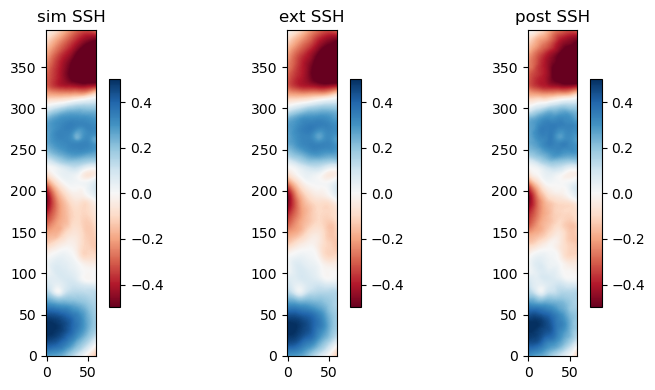

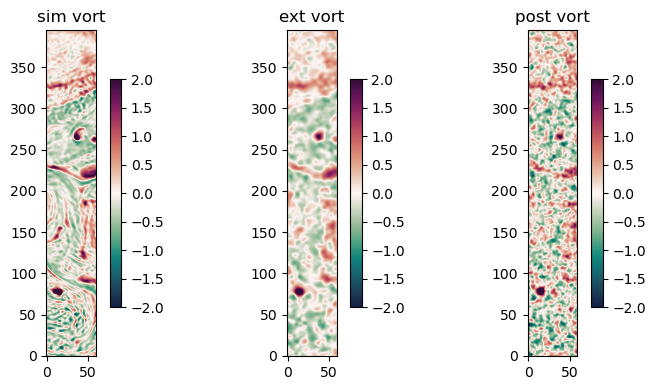

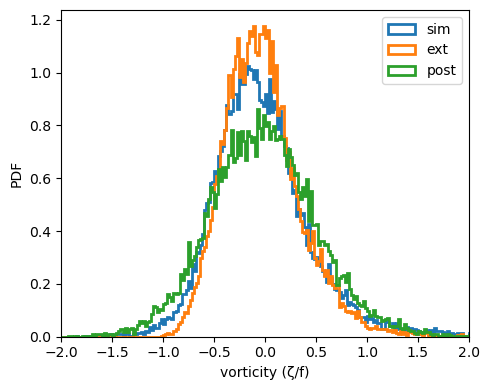

SSH variance (sim ) : 7.503638e-02
SSH variance (post) : 7.495081e-02
SSH variance (sim from above) : 6.823004e-02
SSH variance (post from above) : 7.549647e-02
Vorticity variance (sim ) : 2.721371e-01
Vorticity variance (post) : 2.914670e-01
Vorticity variance (sim from above) : 2.644035e-01
Vorticity variance (post from above) : 2.728880e-01
Vorticity std (sim ) : 0.52167
Vorticity std (post) : 0.53988
SSH post/sim variance ratio       : 0.999
Vorticity post/sim variance ratio : 1.071


In [10]:
#### Now we test the data that we saved before doing the extraction on it 

RESULTS_PATH = f"{PICKLES}/posterior_vorticity_results.pkl"  # computed posteriors in batch
results = load(RESULTS_PATH)
data = results[km]

read_ht_sim   = data['ssh_sim'][t, :, :]
read_ht_ext   = data['ssh_ext'][t, :, :]
read_ht_post  = data['ssh_post'][t, 0, :, :] # take one posterior sample
read_vort_sim = data['sim'][t, :, :]
read_vort_ext = data['ext'][t, :, :]
read_vort_post= data['post'][t, 0, :, :]

# ssh fields
fig, axes = plt.subplots(1, 3, figsize=(8,4))
fields = [read_ht_sim, read_ht_ext, read_ht_post] # ssh fields
titles = ["sim SSH", "ext SSH", "post SSH"]

for ax, fld, ttl in zip(axes, fields, titles):
    im = ax.imshow(fld, origin="lower", cmap="RdBu", vmin=-0.5, vmax=0.5)
    ax.set_title(ttl)
    fig.colorbar(im, ax=ax, shrink=0.7)

plt.tight_layout()
plt.show()

# vorticity fields
fig, axes = plt.subplots(1, 3, figsize=(8,4))
fields = [read_vort_sim, read_vort_ext, read_vort_post] # vorticity fields
titles = ["sim vort", "ext vort", "post vort"]

for ax, fld, ttl in zip(axes, fields, titles):
    im = ax.imshow(fld, origin="lower", cmap=cmocean.cm.curl, vmin=-2, vmax=2)
    ax.set_title(ttl)
    fig.colorbar(im, ax=ax, shrink=0.7)

plt.tight_layout()
plt.show()

# pdfs
read_vort_sim  = finite_flat(read_vort_sim)
read_vort_ext  = finite_flat(read_vort_ext)
read_vort_post = finite_flat(read_vort_post)

bins = np.linspace(-3, 3, 301)

plt.figure(figsize=(5,4))
plt.hist(read_vort_sim,  bins=bins, histtype='step', density=True, lw=2, label='sim')
plt.hist(read_vort_ext,  bins=bins, histtype='step', density=True, lw=2, label='ext')
plt.hist(read_vort_post, bins=bins, histtype='step', density=True, lw=2, label='post')
plt.xlim(-2, 2)
plt.xlabel("vorticity (ζ/f)")
plt.ylabel("PDF")
plt.legend()
plt.tight_layout()
plt.show()

print(f"SSH variance (sim ) : {np.nanvar(read_ht_sim):.6e}")
print(f"SSH variance (post) : {np.nanvar(read_ht_post):.6e}")
print(f"SSH variance (sim from above) : {np.nanvar(ht_sim):.6e}")
print(f"SSH variance (post from above) : {np.nanvar(ht_post):.6e}")

print(f"Vorticity variance (sim ) : {np.nanvar(read_vort_sim):.6e}")
print(f"Vorticity variance (post) : {np.nanvar(read_vort_post):.6e}")
print(f"Vorticity variance (sim from above) : {np.nanvar(sim_vort):.6e}")
print(f"Vorticity variance (post from above) : {np.nanvar(post_vort):.6e}")

print(f"Vorticity std (sim ) : {np.nanstd(read_vort_sim):.5f}")
print(f"Vorticity std (post) : {np.nanstd(read_vort_post):.5f}")

print(f"SSH post/sim variance ratio       : {np.nanvar(read_ht_post) / np.nanvar(read_ht_sim):.3f}")
print(f"Vorticity post/sim variance ratio : {np.nanvar(read_vort_post) / np.nanvar(read_vort_sim):.3f}")


dict_keys([0, 1, 2, 4, 8, 16])
Color limits: vmin=-2, vmax=2


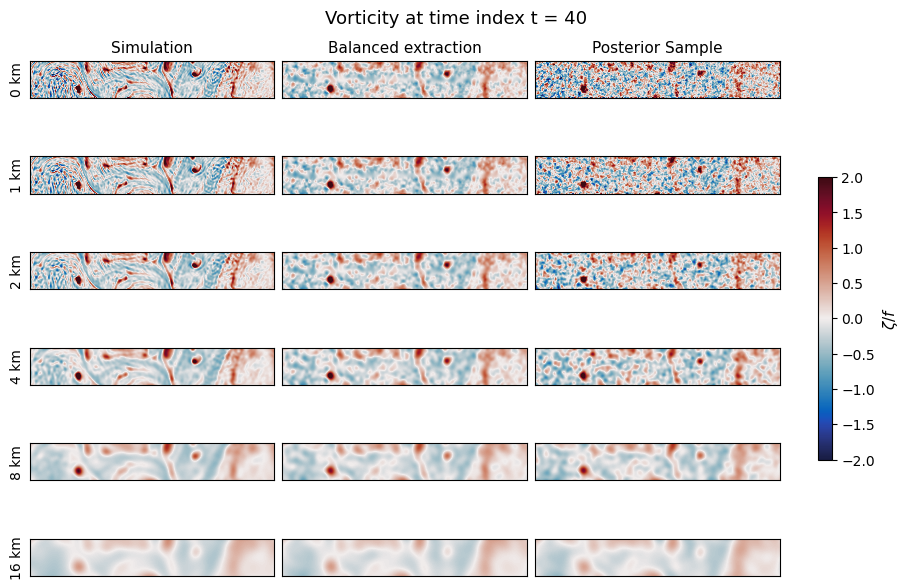

In [11]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cmocean

PICKLES = "./pickles"
RESULTS_PATH = f"{PICKLES}/posterior_vorticity_results.pkl"

# -------------------------
# Load results dict
# -------------------------
def load(file): 
    with open(file, "rb") as f:
        results = pickle.load(f)
    return results

results = load(RESULTS_PATH)
print(results.keys())
# Scales and time/sample choices
SCALES = [0, 1, 2, 4, 8, 16]  # km
t_idx  = 40                   # time index to plot
use_posterior_mean = False    # True: mean over samples, False: pick one sample
s_idx  = 0                    # which sample if not using mean

# -------------------------
# Work out global color limits for all panels
# -------------------------
all_fields = []

for km in SCALES:
    sim_vort = results[km]["sim"][t_idx]          # (ny, nx)
    ext_vort = results[km]["ext"][t_idx]          # (ny, nx)
    if use_posterior_mean:
        post_vort = results[km]["post"][t_idx].mean(axis=0)  # (ny, nx)
    else:
        post_vort = results[km]["post"][t_idx, s_idx]        # (ny, nx)

    all_fields.extend([sim_vort, ext_vort, post_vort])

all_fields = np.stack(all_fields)
vmax = 2
vmin = -vmax

print(f"Color limits: vmin={vmin:.3g}, vmax={vmax:.3g}")

# -------------------------
# Make the panel plot
# -------------------------
n_scales = len(SCALES)
fig, axes = plt.subplots(
    n_scales, 3,
    figsize=(9, 1.0* n_scales),
    constrained_layout=True
)

# If only one scale, axes comes back 1D; make it 2D for uniform indexing
if n_scales == 1:
    axes = axes[np.newaxis, :]

titles = ["Simulation", "Balanced extraction", "Posterior Sample"]

im = None

for i, km in enumerate(SCALES):
    sim_vort = results[km]["sim"][t_idx]
    ext_vort = results[km]["ext"][t_idx]
    if use_posterior_mean:
        post_vort = results[km]["post"][t_idx].mean(axis=0)
    else:
        post_vort = results[km]["post"][t_idx, s_idx]

    fields = [sim_vort, ext_vort, post_vort]

    for j, (ax, field) in enumerate(zip(axes[i], fields)):
        im = ax.imshow(
            field.T,
            origin="lower",
            cmap=cmocean.cm.balance,
            vmin=vmin, vmax=vmax
        )
        if i == 0:
            ax.set_title(titles[j], fontsize=11)

        ax.set_xticks([])
        ax.set_yticks([])

        # Label the row by scale on the left
        if j == 0:
            ax.set_ylabel(f"{km} km", fontsize=10)

# One shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
cbar.set_label(r"$\zeta/f$", fontsize=11)

fig.suptitle(f"Vorticity at time index t = {t_idx}", fontsize=13)
plt.savefig(f"vorticity_panels_t{t_idx}.png", dpi=150)
plt.show()


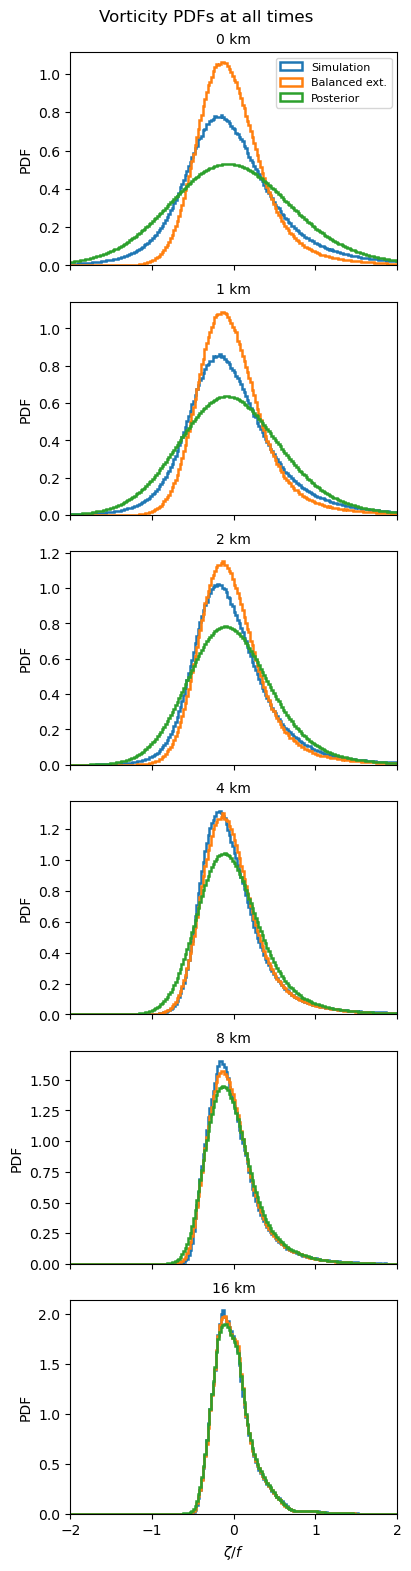

In [12]:
import numpy as np
import matplotlib.pyplot as plt

t_idx = 40   

fig, axes = plt.subplots(
    len(SCALES), 1,
    figsize=(4, 2.6 * len(SCALES)),
    sharex=True,
    constrained_layout=True
)

if len(SCALES) == 1:
    axes = [axes]

for ax, km in zip(axes, SCALES):
    sim  = results[km]["sim"].ravel()
    ext  = results[km]["ext"].ravel()
    post = results[km]["post"].ravel()     # all samples, all gridpoints

    ax.hist(sim,  bins=common_bins, density=True, histtype="step",
            linewidth=1.8, label="Simulation")
    ax.hist(ext,  bins=common_bins, density=True, histtype="step",
            linewidth=1.8, label="Balanced ext.")
    ax.hist(post, bins=common_bins, density=True, histtype="step",
            linewidth=1.8, label="Posterior")

    ax.set_ylabel("PDF")
    ax.set_ylim(bottom=0)
    ax.set_xlim(-2, 2)
    ax.set_title(f"{km} km", fontsize=10)

axes[-1].set_xlabel(r"$\zeta/f$")
axes[0].legend(loc="upper right", fontsize=8)

fig.suptitle(f"Vorticity PDFs at all times", fontsize=12)
plt.savefig(f"vorticity_pdfs_allt.png", dpi=150)
plt.show()


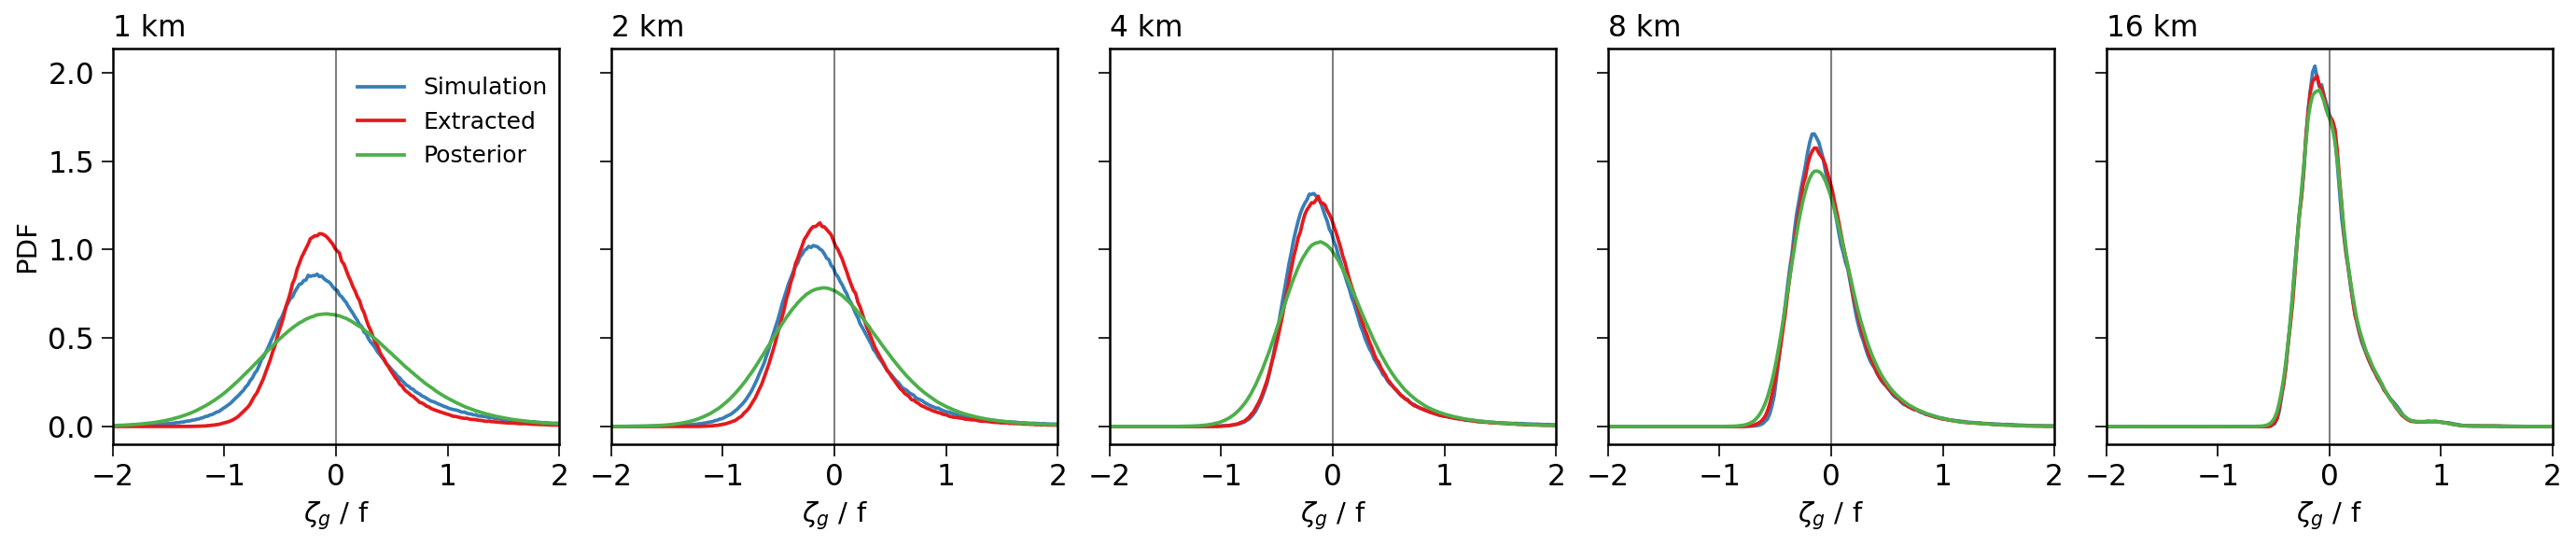

In [13]:
swot.set_plot_style()

SCALES = [1, 2, 4, 8, 16] # drop the 0

def finite_flat_one(arr):
    v = np.asarray(arr, dtype=float).ravel()
    return v[np.isfinite(v)]

def pdf_shared_bins(*arrays, bins=300, lo=-3, hi=3):
    edges   = np.linspace(lo, hi, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    pdfs = []
    for arr in arrays:
        v = finite_flat_one(arr)
        v = v[(v >= lo) & (v <= hi)]
        h, _ = np.histogram(v, bins=edges, density=True)
        pdfs.append(h)
    return centers, pdfs

fig, axes = plt.subplots(
    1, len(SCALES),
    figsize=(3.7 * len(SCALES), 4.0),
    sharex=True, sharey=True,
    dpi=150
)

pdfs = {}

for ax, scale in zip(axes, SCALES):
    data = results[scale]
    
    x, (pdf_sim, pdf_ext, pdf_post) = pdf_shared_bins(
        data["sim"], data["ext"], data["post"],
        bins=300, lo=-3, hi=3
    )

    pdfs[scale] = (x, pdf_sim, pdf_ext, pdf_post)  # for moments later

    # Plot
    ax.plot(x, pdf_sim,  lw=1.8, label="Simulation")
    ax.plot(x, pdf_ext,  lw=1.8, label="Extracted")
    ax.plot(x, pdf_post, lw=1.8, label="Posterior")

    ax.set_xlim(-2.0, 2.0)
    ax.set_title(f"{scale} km", loc="left", fontsize=15)
    ax.set_xlabel(r"$\zeta_g$ / f", fontsize=14)
    ax.axvline(0, color="k", lw=1.0, ls="-", alpha=0.5)
    ax.tick_params(axis="both", which="major", labelsize=15)

axes[0].set_ylabel("PDF", fontsize=14)

# Shared legend
handles, labels = axes[-1].get_legend_handles_labels()
axes[0].legend(
    handles, labels,
    loc="upper right",
    frameon=False,
    fontsize=12,
    bbox_to_anchor=(1.02, 0.98)
)

fig.tight_layout()
plt.savefig("PDFS.pdf")
plt.show()

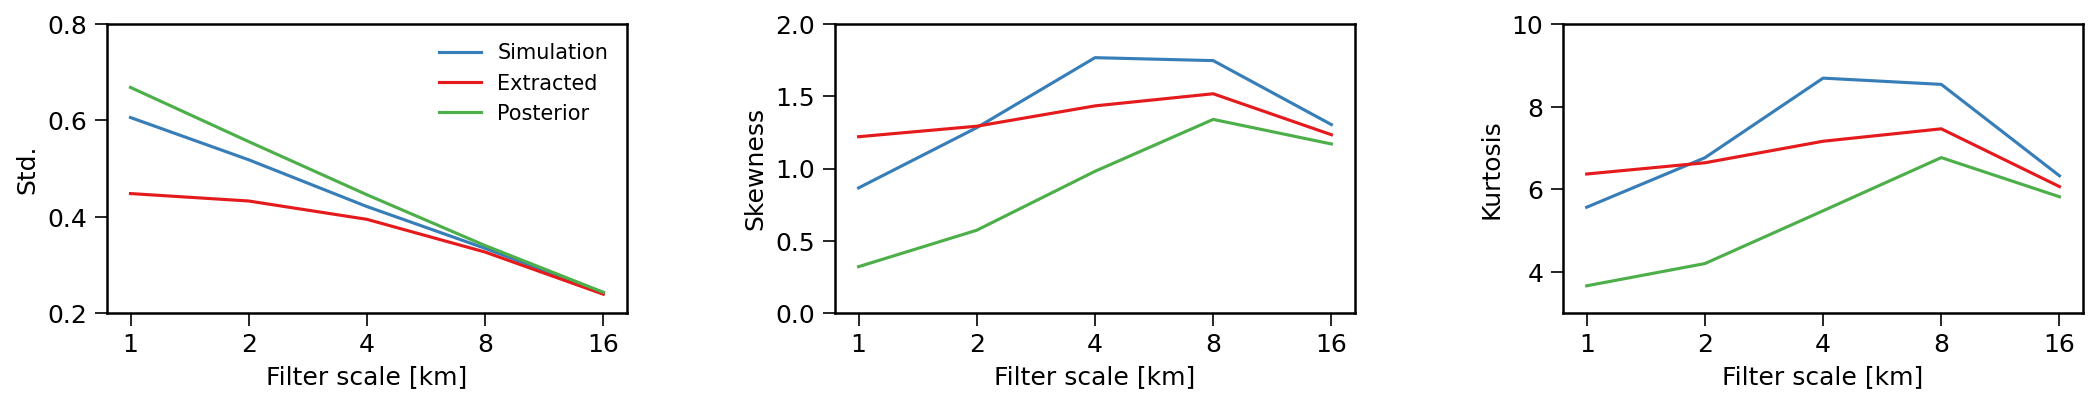

In [14]:
def hist_moments(x, p):
    dx = x[1] - x[0]
    w = p * dx
    m1 = np.sum(x * w)
    c = x - m1
    m2 = np.sum((c**2) * w)
    m3 = np.sum((c**3) * w)
    m4 = np.sum((c**4) * w)
    skew = m3 / (m2 ** 1.5)
    kurt = m4 / (m2 ** 2)
    return m1, m2, skew, kurt

scales = []
var_sim, var_ext, var_post = [], [], []
skw_sim, skw_ext, skw_post = [], [], []
kur_sim, kur_ext, kur_post = [], [], []

for km, (x, pdf_sim, pdf_ext, pdf_post) in pdfs.items():
    _, v_s, s_s, k_s = hist_moments(x, pdf_sim)
    _, v_e, s_e, k_e = hist_moments(x, pdf_ext)
    _, v_p, s_p, k_p = hist_moments(x, pdf_post)

    scales.append(km)
    var_sim.append(v_s); var_ext.append(v_e); var_post.append(v_p)
    skw_sim.append(s_s); skw_ext.append(s_e); skw_post.append(s_p)
    kur_sim.append(k_s); kur_ext.append(k_e); kur_post.append(k_p)
    
std_sim  = np.sqrt(var_sim)
std_ext  = np.sqrt(var_ext)
std_post = np.sqrt(var_post)

plt.figure(figsize=(17, 2.5), dpi=150)
ax1 = plt.subplot(1, 3, 1)
plt.subplots_adjust(wspace=0.4)
ax1.plot(scales, std_sim,  "-",lw=1.5, label="Simulation")
ax1.plot(scales, std_ext,  "-",lw=1.5, label="Extracted")
ax1.plot(scales, std_post, "-",lw=1.5, label="Posterior")
ax1.set_ylabel("Std.", fontsize=12)
ax1.tick_params(axis="both", labelsize=12)
ax1.legend(frameon=False, fontsize=10, ncols=1)
ax1.set_xticks(scales)
ax1.set_xticklabels(scales)
ax1.set_xlabel("Filter scale [km]", fontsize=12)
ax1.set_ylim(0.2, 0.8)

ax2 = plt.subplot(1, 3, 2, sharex=ax1)
ax2.plot(scales, skw_sim,  "-", lw=1.5)
ax2.plot(scales, skw_ext,  "-", lw=1.5)
ax2.plot(scales, skw_post, "-", lw=1.5)
ax2.set_ylabel("Skewness", fontsize=12)
ax2.set_xlabel("Filter scale [km]", fontsize=12)
ax2.tick_params(axis="both", labelsize=12)
ax2.set_ylim(0.0, 2.0)

ax3 = plt.subplot(1, 3, 3, sharex=ax1)
ax3.plot(scales, kur_sim,  "-", lw=1.5)
ax3.plot(scales, kur_ext,  "-", lw=1.5)
ax3.plot(scales, kur_post, "-", lw=1.5)
ax3.set_ylabel("Kurtosis", fontsize=12)
ax3.set_xlabel("Filter scale [km]", fontsize=12)
ax3.tick_params(axis="both", labelsize=12)
ax3.set_ylim(3, 10)

for ax in [ax1, ax2, ax3]:
    ax.set_xscale("log", base=2)
    ax.set_xticks(SCALES)
    ax.set_xticklabels([str(k) for k in SCALES])

plt.subplots_adjust(hspace=0.45)
#plt.tight_layout()
plt.savefig("vort-moments.pdf")
plt.show()

In [15]:
for km, (x, pdf_sim, pdf_ext, pdf_post) in pdfs.items():
    m_s, v_s, s_s, k_s = hist_moments(x, pdf_sim)
    m_e, v_e, s_e, k_e = hist_moments(x, pdf_ext)
    m_p, v_p, s_p, k_p = hist_moments(x, pdf_post)

    # ---- PRINT MOMENTS FOR THIS SCALE ----
    print(f"\n=== Scale {km} km ===")
    print(f" Simulation: mean={m_s:.4f}, var={v_s:.4f}, skew={s_s:.4f}, kurt={k_s:.4f}")
    print(f" Extracted : mean={m_e:.4f}, var={v_e:.4f}, skew={s_e:.4f}, kurt={k_e:.4f}")
    print(f" Posterior : mean={m_p:.4f}, var={v_p:.4f}, skew={s_p:.4f}, kurt={k_p:.4f}")

    scales.append(km)
    var_sim.append(v_s); var_ext.append(v_e); var_post.append(v_p)
    skw_sim.append(s_s); skw_ext.append(s_e); skw_post.append(s_p)
    kur_sim.append(k_s); kur_ext.append(k_e); kur_post.append(k_p)



=== Scale 1 km ===
 Simulation: mean=-0.0256, var=0.3671, skew=0.8657, kurt=5.5613
 Extracted : mean=-0.0122, var=0.2006, skew=1.2201, kurt=6.3665
 Posterior : mean=-0.0134, var=0.4469, skew=0.3200, kurt=3.6561

=== Scale 2 km ===
 Simulation: mean=-0.0186, var=0.2684, skew=1.2829, kurt=6.7605
 Extracted : mean=-0.0120, var=0.1870, skew=1.2930, kurt=6.6385
 Posterior : mean=-0.0123, var=0.3090, skew=0.5726, kurt=4.1952

=== Scale 4 km ===
 Simulation: mean=-0.0129, var=0.1772, skew=1.7676, kurt=8.6908
 Extracted : mean=-0.0115, var=0.1555, skew=1.4338, kurt=7.1608
 Posterior : mean=-0.0115, var=0.1984, skew=0.9806, kurt=5.4750

=== Scale 8 km ===
 Simulation: mean=-0.0107, var=0.1116, skew=1.7473, kurt=8.5392
 Extracted : mean=-0.0108, var=0.1065, skew=1.5177, kurt=7.4621
 Posterior : mean=-0.0105, var=0.1155, skew=1.3401, kurt=6.7642

=== Scale 16 km ===
 Simulation: mean=-0.0099, var=0.0585, skew=1.3041, kurt=6.3227
 Extracted : mean=-0.0099, var=0.0570, skew=1.2341, kurt=6.0614
 Po

In [ ]:
# from scipy import linalg as la 
P = load(f"{PICKLES}/posterior_balanced_extraction_synth_NA_tmean_sm_2km.pkl")
ht_all = load(f"{PICKLES}/balanced_extraction_synth_NA_tmean_sm_2km.pkl")

T, ny, nx = ht_all.shape

time_index = 0  
mu_cm = (ht_all[time_index] * 100.0).ravel()  

eps = 1e-8 * float(np.mean(np.diag(P)))
L_P, lower = la.cho_factor(P + eps * np.eye(P.shape[0]), lower=True)

# --- Balanced posterior sample: x ~ N(mu_cm, P) ---
z = np.random.randn(P.shape[0])
sample_cm = mu_cm + L_P @ z
ht_post_bal = (sample_cm.reshape(ny, nx)) / 100.0  

ht_post_bal = ht_post_bal[np.newaxis, ...]
print(ht_post_bal.shape)  # (1, ny, nx)


---- KaRIn spectrum parameters ----
Amp. balanced   :   1.5641e+05 ± 2.23e+03
lambda balanced :   2.7865e+02 ± 2.49e+00
slope balanced  :   4.8172e+00 ± 5.29e-02
Amp. noise      :   4.3146e+01 ± 6.23e+01
lambda noise    :   1.0000e+02 ± 8.74e+01
slope noise     :   1.7551e+00 ± 3.89e-02


---- Nadir spectrum parameters ----
Fitted Nadir noise floor N = 322.93748760452667 ± 1.06e+01



(<Figure size 960x480 with 2 Axes>,
 array([<Axes: title={'center': '2km'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>,
        <Axes: >], dtype=object))

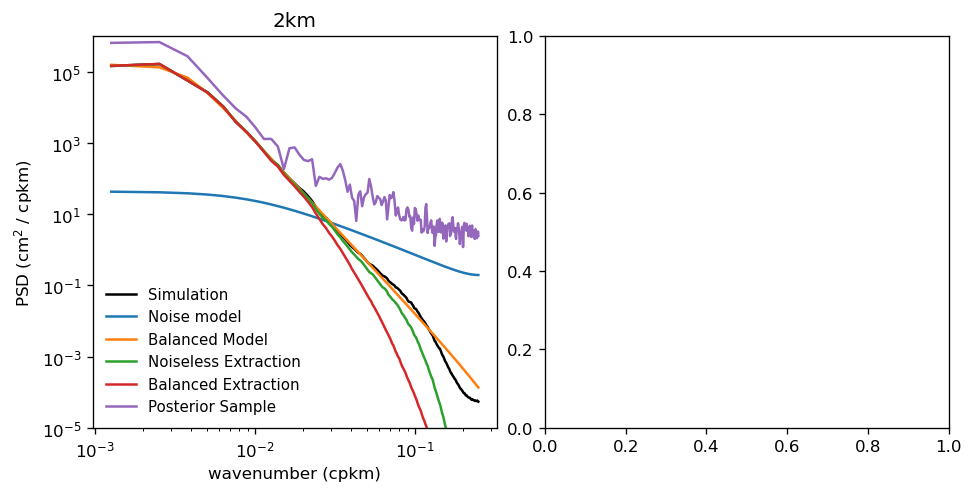

In [57]:
import importlib
import JWS_SWOT_toolbox as swot
importlib.reload(swot)

def plot_spectral_fits(karin, nadir, poptcwg_karin, poptcwg_nadir, spectrum, spectrum2, spectrum3, figsize=(8, 4), dpi=120):
    
    # Get the one-sided spectra
    k_karin = karin.wavenumbers_cpkm[int(karin.track_length/2):]  # units [1/m]
    karin_spec_sample_mean = karin.spec_alongtrack_av[int(karin.track_length/2):]
    k_nadir = nadir.wavenumbers_cpkm[int(nadir.track_length/2):]  # units [1/m]
    nadir_spec_sample_mean = nadir.spec_alongtrack_av[int(nadir.track_length/2):]
    spectrum = spectrum[int(karin.track_length/2):]
    spectrum2 = spectrum2[int(karin.track_length/2):]
    spectrum3 = spectrum3[int(karin.track_length/2):]
    
    # Put the wavenumbers through the models to get the functional form
    spbalanced = swot.balanced_model_tapered(k_karin[1:], *poptcwg_karin[0:3])
    spunbalanced = swot.unbalanced_model_tapered(k_karin, *poptcwg_karin[3:7])
    spnoise_nadir = swot.nadir_noise_model(k_nadir, poptcwg_nadir[0])
    
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi, constrained_layout=True)
    
    # ----- Panel 1: KaRIn -----
    k_km = k_karin # wavenumbers in cycles/km
    axs[0].loglog(k_km[1:], karin_spec_sample_mean[1:], 'k-', label='Simulation')
    axs[0].loglog(k_km[1:], spunbalanced[1:],label=r'Noise model')
    axs[0].loglog(k_km[1:], spbalanced,label=r'Balanced Model')
    axs[0].loglog(k_km[1:], spectrum[1:], '-', label='Noiseless Extraction')
    axs[0].loglog(k_km[1:], spectrum2[1:], '-', label='Balanced Extraction')
    axs[0].loglog(k_km[1:], spectrum3[1:], '-', label='Posterior Sample')
    axs[0].set_xlabel('wavenumber (cpkm)')
    axs[0].set_ylabel('PSD (cm$^2$ / cpkm)')
    # axs[0].set_xlim(1e-3, 3e-1)
    axs[0].set_ylim(1e-5, 1e6)
    axs[0].set_title('2km')
    axs[0].legend(loc='lower left', frameon=False, fontsize=9)
    
    
    return fig, axs

# -------------------------
# Spectral fit (cm)
# -------------------------
noisy_karin  = karin_obj.ssh_noisy * 100.0    # our synthetic SWOT data in m to cm
noisy_nadir = nadir_obj.ssh_noisy * 100.0     # our synthetic nadir data in m to cm

ssh_noisy_xr = xr.DataArray(
    noisy_karin,
    coords=[np.arange(karin_obj.ssha.shape[0]), karin_obj.y_coord_km, karin_obj.x_coord_km],
    dims=["sample", "line", "pixel"],
)
spec_ssh_noisy = swot.mean_power_spectrum(ssh_noisy_xr, karin_obj.window, "line", ["sample", "pixel"])

nad_noisy_xr = xr.DataArray(
    noisy_nadir,
    coords=[np.arange(karin_obj.ssha.shape[0]), nadir_obj.y_coord_km],
    dims=["sample", "nadir_line"],
)
spec_nad_noisy = swot.mean_power_spectrum(nad_noisy_xr, nadir_obj.window, "nadir_line", ["sample"])

ht_ext = np.asarray(load(f"{PICKLES}/balanced_extraction_synth_NA_tmean_sm_2km_nonoise.pkl"), dtype=float)
ssh_nonoise_xr = xr.DataArray(
    ht_ext,
    coords=[np.arange(karin_obj.ssha.shape[0]), karin_obj.y_coord_km, karin_obj.x_coord_km],
    dims=["sample", "line", "pixel"],
)
spec_ssh_nonoise = swot.mean_power_spectrum(ssh_nonoise_xr * 100, karin_obj.window, "line", ["sample", "pixel"])

ht_bal = np.asarray(load(f"{PICKLES}/balanced_extraction_synth_NA_tmean_sm_2km.pkl"), dtype=float)
ssh_bal_xr = xr.DataArray(
    ht_bal,
    coords=[np.arange(karin_obj.ssha.shape[0]), karin_obj.y_coord_km, karin_obj.x_coord_km],
    dims=["sample", "line", "pixel"],
)
spec_ssh_extraction = swot.mean_power_spectrum(ssh_bal_xr * 100, karin_obj.window, "line", ["sample", "pixel"])

ssh_post_xr = xr.DataArray(
    ht_post_bal,
    coords=[np.arange(1), karin_obj.y_coord_km, karin_obj.x_coord_km],
    dims=["sample", "line", "pixel"],
)
spec_ssh_post = swot.mean_power_spectrum(ssh_post_xr*100, karin_obj.window, "line", ["sample", "pixel"])

# Fit spectra to get parameters
p_karin, _   = swot.fit_spectrum(karin_obj, spec_ssh_noisy, swot.karin_model)
p_nadir, _   = swot.fit_nadir_spectrum(nadir_obj, spec_nad_noisy, p_karin)
k_karin = karin_obj.wavenumbers_cpkm[int(karin_obj.track_length/2):]
spbalanced = swot.balanced_model_tapered(k_karin[1:], *p_karin[0:3]) # our prior
plot_spectral_fits(karin_obj, nadir_obj, p_karin, p_nadir, spec_ssh_nonoise, spec_ssh_extraction, spec_ssh_post)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


NameError: name 'spbalanced' is not defined

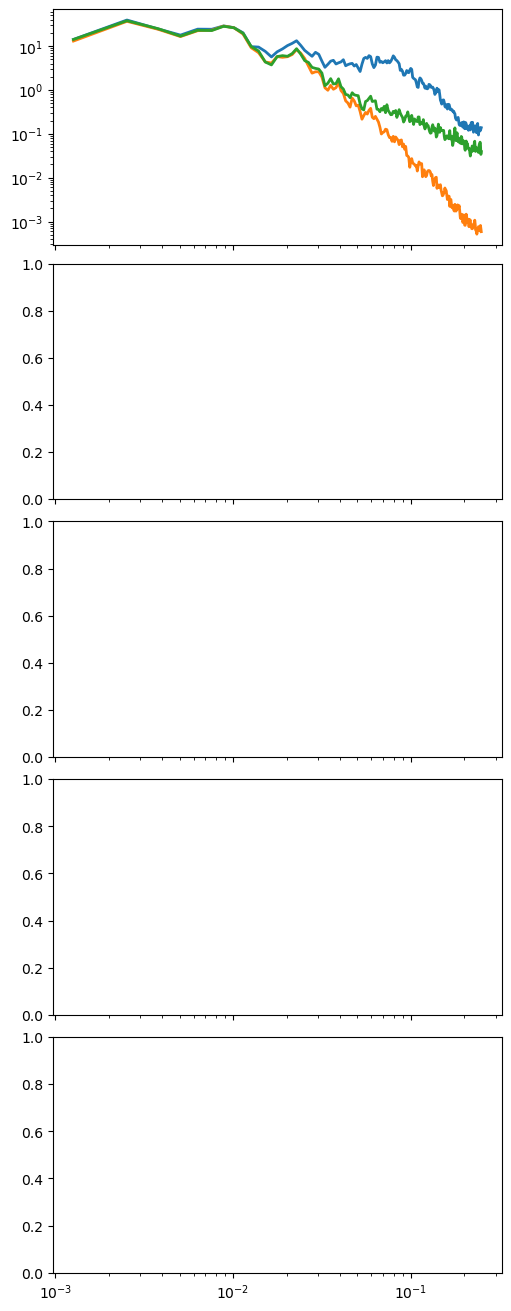

┌ Warning: CHOLMOD version incompatibility
│ 
│ Julia was compiled with CHOLMOD version 4.0.4. It is
│ currently linked with version 5.3.1.
│ This might cause Julia to terminate when working with
│ sparse matrix factorizations, e.g. solving systems of
│ equations with \.
│ 
│ It is recommended that you use Julia with the same major
│ version of CHOLMOD as the one used during the build, or
│ download the generic binaries from www.julialang.org,
│ which ship with the correct versions of all dependencies.
└ @ SparseArrays.CHOLMOD ~/miniconda3/envs/d3/share/julia/stdlib/v1.10/SparseArrays/src/solvers/cholmod.jl:206


In [9]:
import pickle
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import JWS_SWOT_toolbox as swot

# Assume:
#   results[km] = {"sim":  (T, ny, nx),
#                  "ext":  (T, ny, nx),
#                  "post": (T, Nsamp, ny, nx)}
# and swot, karin_NA, etc. are already imported from earlier.

PICKLES = "./pickles"

# Load Karin NA object for geometry / window / k grid
with open(f"{PICKLES}/karin_NA_tmean.pkl", "rb") as f:
    karin_obj = pickle.load(f)
with open(f"{PICKLES}/nadir_NA_tmean.pkl", "rb") as f:
    nadir_obj = pickle.load(f)

SCALES = [0, 2, 4, 8, 16]
t_idx  = 4                # time index to use
use_posterior_mean = True  # or False to use a single posterior sample
s_idx  = 0                 # which sample if not using mean


def one_sided_acrosstrack_averaged_spectrum(field2d, karin_obj):
    """
    field2d: (ny, nx) vorticity map
    Returns k_onesided (cpkm), spec_onesided (same units as input^2 * km).
    """
    ny_dim, nx_dim = field2d.shape

    # Build DataArray with across-track 'pixel' and along-track 'line'
    coords = {
        "pixel": np.arange(ny_dim) * karin_obj.dy_km,  # across-track [km]
        "line":  np.arange(nx_dim) * karin_obj.dx_km,  # along-track  [km]
    }
    da = xr.DataArray(field2d - np.nanmean(field2d),
                      coords=coords, dims=["pixel", "line"])

    # Two-sided spectrum along 'line', averaged over 'pixel'
    spec_2s = swot.mean_power_spectrum(da,
                                       window=karin_obj.window,
                                       dim="line",
                                       average_dims=["pixel"])

    # Build matching k grid from Karin object
    k_all = karin_obj.wavenumbers_cpkm      # full two-sided k (len = track_length)
    track_len = karin_obj.track_length

    # Take positive wavenumbers (second half) and drop k=0
    # Use the same slicing pattern as your SSH code
    istart = int(track_len // 2)
    k_pos = k_all[istart:][1:]              # (n_k,)
    spec_1s = spec_2s[istart:][1:]          # (n_k,)

    return k_pos, np.asarray(spec_1s)


# -------------------------
# Compute spectra for all scales
# -------------------------
fig, axes = plt.subplots(
    len(SCALES), 1,
    figsize=(5, 2.6 * len(SCALES)),
    sharex=True,
    constrained_layout=True,
)

if len(SCALES) == 1:
    axes = [axes]

for ax, km in zip(axes, SCALES):
    # Pull out vorticity fields at this time
    sim_vort = results[km]["sim"][t_idx]   # (ny, nx)
    ext_vort = results[km]["ext"][t_idx]   # (ny, nx)
    if use_posterior_mean:
        post_vort = results[km]["post"][t_idx].mean(axis=0)   # (ny, nx)
    else:
        post_vort = results[km]["post"][t_idx, s_idx]         # (ny, nx)

    # One-sided along-track spectra (across-track-averaged)
    k, S_sim  = one_sided_acrosstrack_averaged_spectrum(sim_vort.T,  karin_obj)
    _, S_ext  = one_sided_acrosstrack_averaged_spectrum(ext_vort.T,  karin_obj)
    _, S_post = one_sided_acrosstrack_averaged_spectrum(post_vort.T, karin_obj)

    ax.loglog(k, S_sim,  label="Simulation",     lw=2)
    ax.loglog(k, S_ext,  label="Balanced ext.",  lw=2)
    ax.loglog(k, S_post, label="Posterior",      lw=2)
    ax.loglog(k, k**2 * 100*spbalanced, label="Balanced Model",      lw=2)

    ax.set_ylabel("PSD")
    ax.set_title(f"{km} km", fontsize=10)
    ax.grid(True, which="both", alpha=0.2)
    ax.set_ylim(1e-10, 1e2)

axes[-1].set_xlabel("Wavenumber (cpkm)")
axes[0].legend(fontsize=8, loc="lower left")

plt.savefig("vorticity_spectra_t{:02d}.png".format(t_idx),
            dpi=150)
plt.show()


In [6]:
# use iterative eigenvalue solver to generate our L's and save them
SCALE_KM = 8
PICKLES = "./pickles"
POST_C_PATH = f"{PICKLES}/posterior_balanced_extraction_synth_NA_tmean_sm_{SCALE_KM}km.pkl"

# low rank solver for no cholesky
# def lowrank_factor(C, k=512, tol=1e-12):
#     C = 0.5*(C + C.T)
#     k = min(max(1, k), C.shape[0]-2)
#     w, Q = eigsh(C, k=k, which='LA')          # top eigenpairs
#     idx = np.argsort(w)[::-1]
#     w, Q = w[idx], Q[:, idx]
#     keep = w > tol
#     w, Q = w[keep], Q[:, keep]
#     L = Q * np.sqrt(w)[None, :]               # C ≈ L L^T
#     print(f"{k}th eigenvalue: {w[min(k-1, len(w)-1)]:.6e}")
#     return L

C = load(POST_C_PATH)
# print(C.shape)
# w, Q = np.linalg.eigh(C)
# wmin, wmax = float(w.min()), float(w.max())

# w_clipped = np.clip(w, 1e-10, None)  # remove negative/zero eigenvalues
# C_psd = (Q * w_clipped) @ Q.T

Lfac, lower  = la.cho_factor(C  + np.eye(C.shape[0]) * 1e-8, lower=True)
Ltri = np.tril(Lfac)
# L = lowrank_factor(C, k=2048)
# with open(L_PATH, "wb") as f:
#     pickle.dump(L, f)
# print(f"Saved low-rank factor to {L_PATH}")

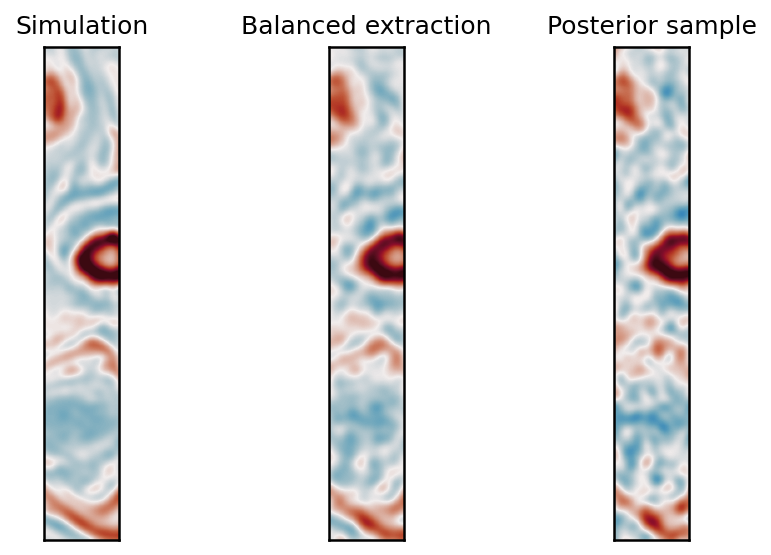

In [24]:
import h5py
# Read in the pickle file L we just saved and plot to check 
SCALE_KM = 8
time = 10 

# L_PATH = f"{PICKLES}/posterior_factor_{SCALE_KM}km.pkl"
# with open(L_PATH, "rb") as f:
#     L = pickle.load(f)
# print("Loaded L:", L.shape)

# # test the Julia extraction
# L_PATH = "./pickles/L_full_synth_NA_tmean_sm_2km.h5"
# with h5py.File(L_PATH, "r") as f:
#     key = 'L'
#     L = f[key][()]  # read the dataset into memory as a NumPy array
#     print("Loaded L:", L.shape, L.dtype)

SCALE_KM = 8
PICKLES = "./pickles"
POST_C_PATH = f"{PICKLES}/posterior_balanced_extraction_synth_NA_tmean_sm_{SCALE_KM}km.pkl"

C = load(POST_C_PATH)
Lfac, lower  = la.cho_factor(C  + np.eye(C.shape[0]) * 1.0e-10, lower=True) # removed the jiiter
Ltri = np.tril(Lfac)

karin = load(KARIN_NA_PATH) # reading in for lats
dx_m = float(karin.dx_km) * 1e3
dy_m = float(karin.dy_km) * 1e3
lat_1d = np.asarray(karin.lat)[0, :, 0] # for gvort

# --- inputs balanced extraction and original fields ---
ht_sim = np.asarray(load(path_nonoise(SCALE_KM)), dtype=float)   # (T, y, x) ground truth
ht_ext = np.asarray(load(path_withnoise(SCALE_KM)), dtype=float) # (T, y, x) balanced extraction
T, ny, nx = ht_ext.shape            

# posterior sample: x ~ N(mu, C) with C ≈ L L^T
mu = (ht_ext[time] * 100.0).ravel() # (n,), cm
z  = np.random.randn(mu.size) 
ht_post = (mu + Ltri @ z).reshape(ny, nx) / 100.0      # meters

# compute the vorticitys
sim_vort = swot.compute_geostrophic_vorticity(ht_sim[time], dx_m, dy_m, lat_1d)
ext_vort = swot.compute_geostrophic_vorticity(ht_ext[time], dx_m, dy_m, lat_1d)
post_vort = swot.compute_geostrophic_vorticity(ht_post, dx_m, dy_m, lat_1d)

fig, axes = plt.subplots(1, 3, figsize=(7, 3.8), sharex=True, sharey=True)
titles = ["Simulation", "Balanced extraction", "Posterior sample"]
vmin, vmax = -1.5, 1.5

ims = []
for ax, data, title in zip(axes, [sim_vort, ext_vort, post_vort], titles):
    im = ax.imshow(data, origin="lower", cmap='cmo.balance', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    ims.append(im)

fig.tight_layout()
plt.savefig(f"posterior_sim_ext_{SCALE_KM}km_t{time}.png", dpi=150)
plt.show()

In [ ]:
# Now we loop over times and samples for the posterior and for each scale and save all the vorticies

SCALES = [0, 2, 4, 8, 16] # loop over, 1km has issue for some reason (?)
NSAMPLES = 10
TIMES = T

results = {}

for km in SCALES: 
    print(f"{km} km")
    sim_vort_all = np.zeros((T, ny, nx))
    ext_vort_all = np.zeros((T, ny, nx))
    post_vort_all = np.zeros((T, NSAMPLES, ny, nx))
    
    ht_sim = np.asarray(load(path_nonoise(km)), dtype=float)   # (T, y, x)
    ht_ext = np.asarray(load(path_withnoise(km)), dtype=float) # (T, y, x)
    T, ny, nx = ht_ext.shape

    L_PATH = f"{PICKLES}/posterior_balanced_extraction_synth_NA_tmean_sm_{km}km.pkl"
    C = load(L_PATH)
    Lfac, lower  = la.cho_factor(C  + np.eye(C.shape[0]) * 1.0e-10, lower=True) # removed the jiiter
    Ltri = np.tril(Lfac)      

    for t in range(0, TIMES):
        print(t)
        # posterior sample: x ~ N(mu, C) with C ≈ L L^T
        mu = (ht_ext[t] * 100).ravel() # in cm for our extraction 
        r = L.shape[1]
        for s in range(0, NSAMPLES): # sample posterior
            z = np.random.randn(r) # new seed
            #ht_post = (mu.ravel() + L @ z).reshape(ny, nx) / 100 # back into meters
            # posterior sample: x ~ N(mu, C) with C ≈ L L^T 
            ht_post = (mu + Ltri @ z).reshape(ny, nx) / 100.0      # meters
            post_vort = swot.compute_geostrophic_vorticity(ht_post, dx_m, dy_m, lat_1d)
            post_vort_all[t, s] = post_vort

        # compute the vorticitys for balanced and sim 
        sim_vort = swot.compute_geostrophic_vorticity(ht_sim[t], dx_m, dy_m, lat_1d)
        ext_vort = swot.compute_geostrophic_vorticity(ht_ext[t], dx_m, dy_m, lat_1d)

        sim_vort_all[t] = sim_vort
        ext_vort_all[t] = ext_vort

    results[km] = dict(
        sim=sim_vort_all,
        ext=ext_vort_all,
        post=post_vort_all,
    )
print("Done")

0 km
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
2 km
0
1
2
3
4
5
6
7
8
9


/scratch/jskinner1/job_44241988/ipykernel_1358606/2790191113.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


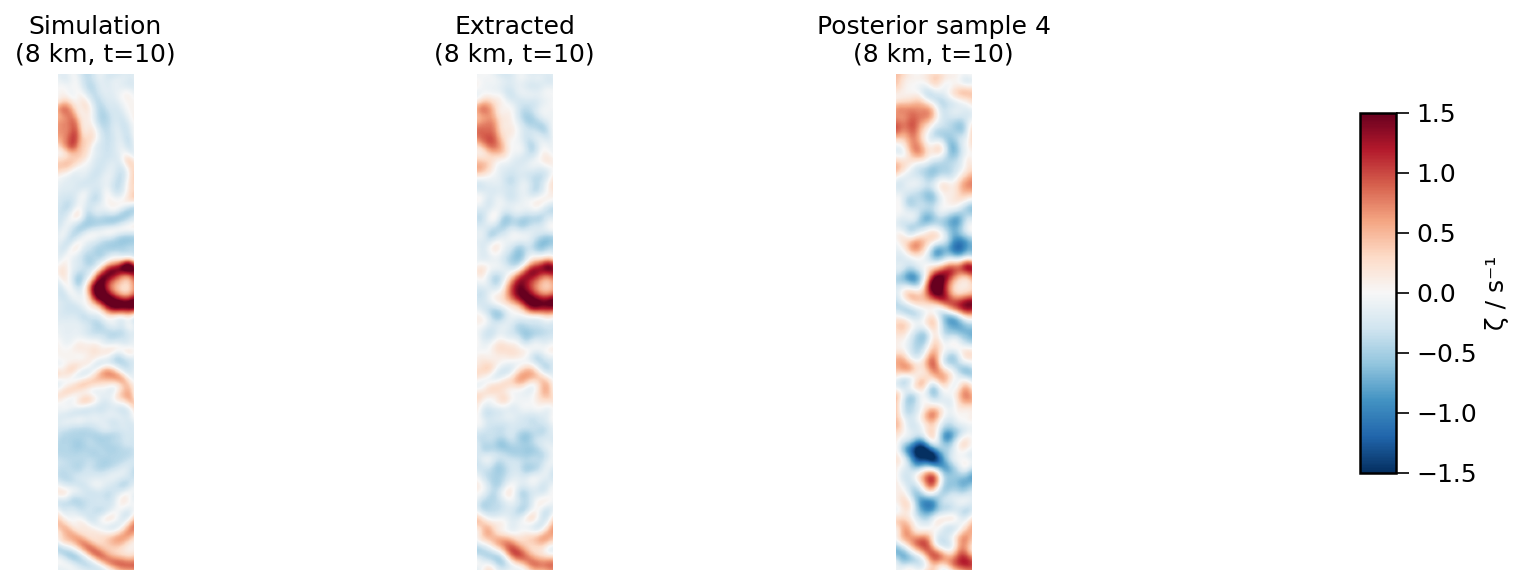

In [20]:
# check the vort calculation
km = 8          
t_show = 10     
sample = 4      # posterior sample 

data = results[km]
sim_vort = data["sim"][t_show]
ext_vort = data["ext"][t_show]
post_vort = data["post"][t_show, sample] 

# --- Setup figure layout ---
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
titles = ["Simulation", "Extracted", f"Posterior sample {sample}"]

# --- Plot each field ---
for ax, field, title in zip(axes, [sim_vort, ext_vort, post_vort], titles):
    im = ax.imshow(field, cmap="RdBu_r", vmin=vmin, vmax=vmax, origin="lower")
    ax.set_title(f"{title}\n({km} km, t={t_show})")
    ax.axis("off")

# --- Add colorbar ---
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cax, label="ζ / s⁻¹")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


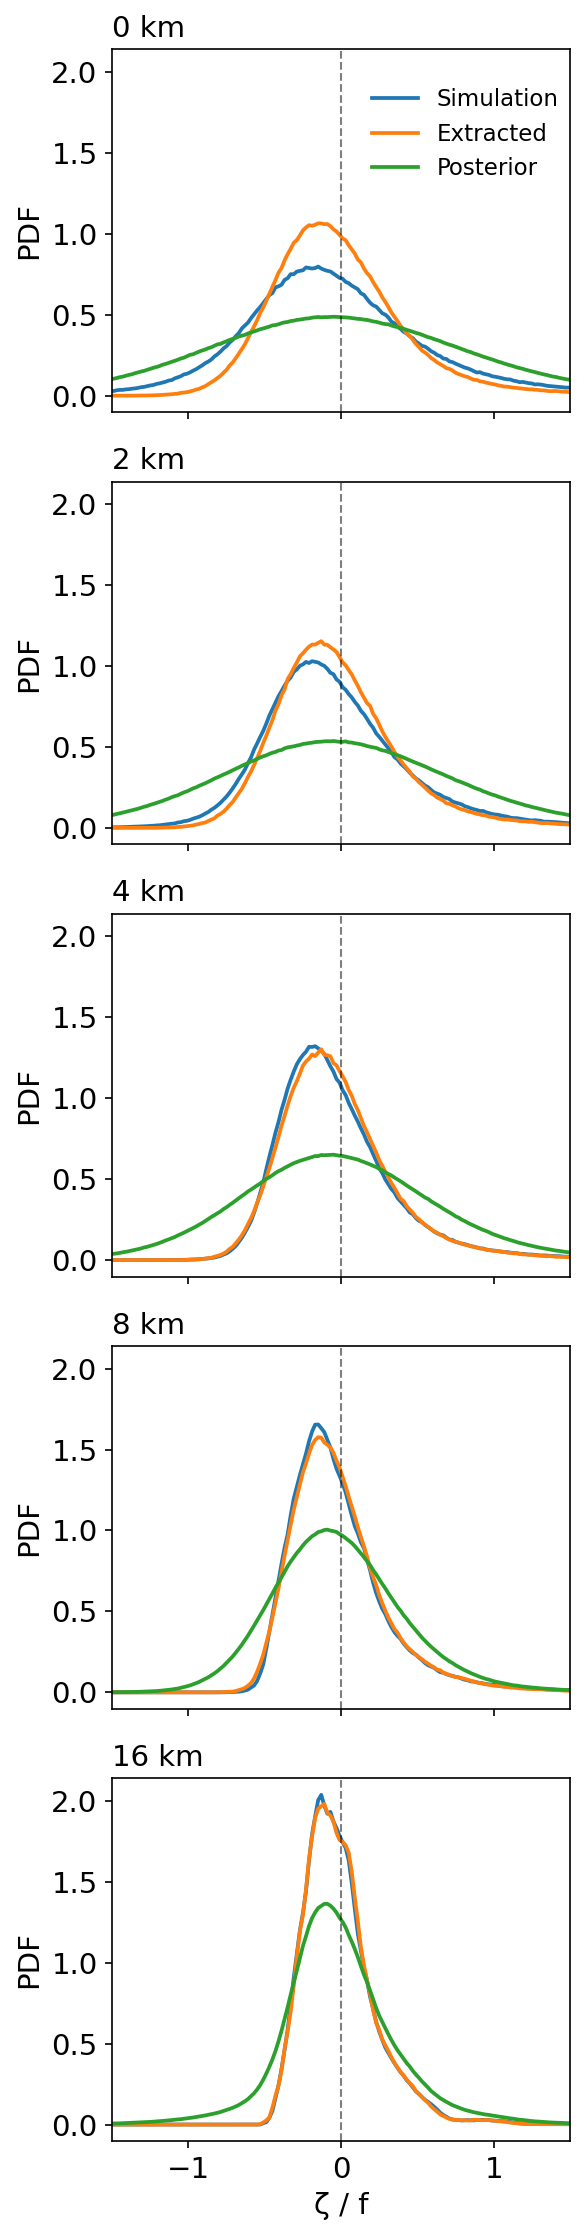

In [18]:
def finite_flat(*arrays):
    outs = []
    for a in arrays:
        v = np.asarray(a, dtype=float).ravel()
        outs.append(v[np.isfinite(v)])
    return outs

def pdf_shared_bins(vals_list, bins=200, clip=(0.5, 99.5)):
    
    allv = np.concatenate(vals_list)
    lo, hi = -2, 2
    edges = np.linspace(lo, hi, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    xs_list, pdf_list = [], []
    for v in vals_list:
        v = np.asarray(v)
        v = v[np.isfinite(v)]
        v = v[(v >= lo) & (v <= hi)] # Drop outliers
        h, _ = np.histogram(v, bins=edges, density=True)
        xs_list.append(centers)
        pdf_list.append(h)
    return centers, pdf_list

fig, axes = plt.subplots(len(SCALES), 1, figsize=(4, 3.0 * len(SCALES)), sharex=True, sharey=True, dpi=150)
swot.set_plot_style()

pdfs = {} 
for ax, km in zip(axes, SCALES):
    data = results[km]

    # Flatten data
    sim_all, = finite_flat(data["sim"])
    ext_all, = finite_flat(data["ext"])
    post_all, = finite_flat(data["post"])

    # Compute PDFs
    x, (pdf_sim, pdf_ext, pdf_post) = pdf_shared_bins(
        [sim_all, ext_all, post_all], bins=200, clip=(-2, 2)
    )

    pdfs[km] = (x, pdf_sim, pdf_ext, pdf_post) # save so we can get moments

    # Plot
    ax.plot(x, pdf_sim, lw=1.8, label="Simulation")
    ax.plot(x, pdf_ext, lw=1.8, label="Extracted")
    ax.plot(x, pdf_post, lw=1.8, label="Posterior")
    ax.set_xlim(-1.5, 1.5)
    ax.set_title(f"{km} km", loc='left', fontsize=14)
    if ax is axes[4]:
        ax.set_xlabel("ζ / f", fontsize=14)
    ax.set_ylabel("PDF", fontsize=14)
    ax.axvline(0, color="k", lw=1.0, ls="--", alpha=0.5)
    ax.tick_params(axis="both", which="major", labelsize=14)

# --- Shared legend & layout ---
handles, labels = axes[-1].get_legend_handles_labels()
axes[0].legend(loc="upper right", frameon=False, fontsize=11, bbox_to_anchor=(1.02, 0.95))
fig.tight_layout()
plt.savefig('PDFS.pdf')
plt.show()

C = LDL^T 
C = P^TLDL^TP is a diagonal with non-zeros on on diagonal some values are -10^_13, set these to zero 
P^TL sqrt(D) is my cholesky factor 

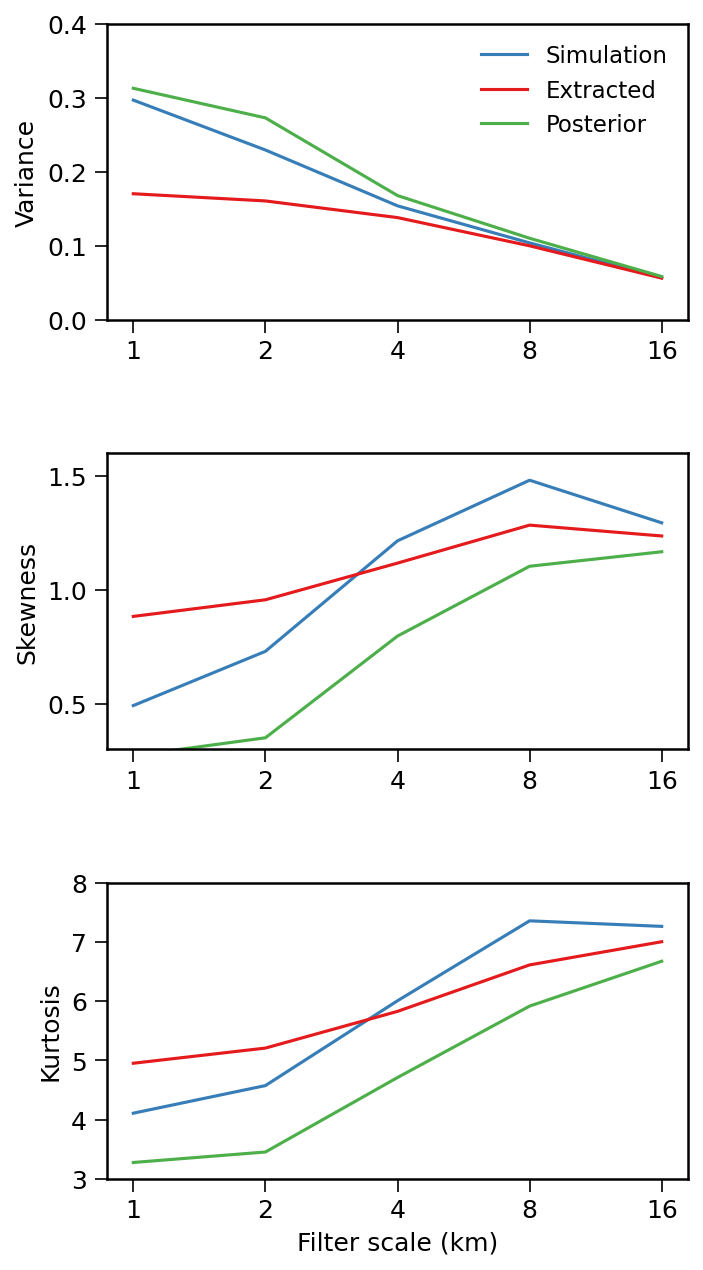

In [14]:
# Load posterior mean on 1 km grid
ht_1km_all = load(MEAN_1KM_PATH)   # (T, y, x)
T, ny, nx = ht_1km_all.shape

n_samples = 10
rng = np.random.default_rng(0)
TIMES_FOR_BINS = min(10, T)  # subset of times to set shared bin edges per scale

def finite_flat(a):
    a = np.asarray(a)
    return a[np.isfinite(a)]

def hist_mean_over_time(vals_T, edges):
    # vals_T: list of 1D finite arrays (one per time)
    H_T = [np.histogram(v, bins=edges, density=True)[0] for v in vals_T]
    return np.mean(np.stack(H_T, axis=0), axis=0)

# Outputs (per-scale)
centers_dict   = {}
H_no_mean_dict = {}
H_wi_mean_dict = {}
H_po_mean_dict = {}

for km in SCALES:
    print(f"{km} km")
    # Load fields already filtered at this scale
    ht_no_all = np.asarray(load(path_nonoise(km)), dtype=float)   # (T, y, x)
    ht_wi_all = np.asarray(load(path_withnoise(km)), dtype=float) # (T, y, x)

    # Smoothing sigmas for posterior samples to match this scale
    sy, sx = sigma_pixels(km, dx_m, dy_m)

    # --- Pass 1: set common bin edges for this scale (subset of times) ---
    los, his = [], []
    for t in range(TIMES_FOR_BINS):
        # simulation & extracted vorticity
        z_no = swot.compute_geostrophic_vorticity_5pt(ht_no_all[t], dx_m, dy_m, lat_1d)
        z_wi = swot.compute_geostrophic_vorticity_5pt(ht_wi_all[t], dx_m, dy_m, lat_1d)

        # posterior samples (vectorized), then smooth to this scale
        mu_cm = ht_1km_all[t].ravel() * 100.0
        N = mu_cm.size
        Z = rng.standard_normal((N, n_samples))                       # (N, S)
        ssh_samples = ((mu_cm[:, None] + L @ Z) / 100.0).T            # (S, N) m
        ssh_samples = ssh_samples.reshape(n_samples, ny, nx)          # (S, y, x)
        ssh_smooth = gaussian_filter(ssh_samples, sigma=(0, sy, sx), mode="nearest")

        a = finite_flat(z_no)
        b = finite_flat(z_wi)
        c = []
        for s in range(n_samples):
            z_po = swot.compute_geostrophic_vorticity_5pt(ssh_smooth[s], dx_m, dy_m, lat_1d)
            c.append(finite_flat(z_po))
        c = np.concatenate(c)

        all_vals = np.concatenate([a, b, c])
        los.append(np.percentile(all_vals, 0.5))
        his.append(np.percentile(all_vals, 99.5))

    lo, hi = float(min(los)), float(max(his))
    edges = np.linspace(lo, hi, 121)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # --- Pass 2: compute time-averaged PDFs for this scale ---
    sim_vals_T, ext_vals_T = [], []
    post_hist_T = []  # we will store histograms directly for the posterior

    for t in range(T):
        print(f"t={t}", end="\r")
        # simulation & extracted
        z_no = swot.compute_geostrophic_vorticity_5pt(ht_no_all[t], dx_m, dy_m, lat_1d)
        z_wi = swot.compute_geostrophic_vorticity_5pt(ht_wi_all[t], dx_m, dy_m, lat_1d)
        sim_vals_T.append(finite_flat(z_no))
        ext_vals_T.append(finite_flat(z_wi))

        # posterior: average of sample histograms at time t
        mu_cm = ht_1km_all[t].ravel() * 100.0
        N = mu_cm.size
        Z = rng.standard_normal((N, n_samples))
        ssh_samples = ((mu_cm[:, None] + L @ Z) / 100.0).T.reshape(n_samples, ny, nx)
        ssh_smooth = gaussian_filter(ssh_samples, sigma=(0, sy, sx), mode="nearest")

        H_pos = []
        for s in range(n_samples):
            z_po = swot.compute_geostrophic_vorticity_5pt(ssh_smooth[s], dx_m, dy_m, lat_1d)
            H_pos.append(np.histogram(finite_flat(z_po), bins=edges, density=True)[0])
        post_hist_T.append(np.mean(np.stack(H_pos, axis=0), axis=0))

    # time-averaged PDFs
    H_no_mean = hist_mean_over_time(sim_vals_T, edges)
    H_wi_mean = hist_mean_over_time(ext_vals_T, edges)
    H_po_mean = np.mean(np.stack(post_hist_T, axis=0), axis=0)

    # store
    centers_dict[km]   = centers
    H_no_mean_dict[km] = H_no_mean
    H_wi_mean_dict[km] = H_wi_mean
    H_po_mean_dict[km] = H_po_mean

# Optional: save to pickle for quick reload later
try:
    pdf_data = {
        "centers": centers_dict,
        "H_no_mean": H_no_mean_dict,
        "H_wi_mean": H_wi_mean_dict,
        "H_po_mean": H_po_mean_dict,
        "n_samples": n_samples,
        "times": T,
        "scales": list(SCALES),
    }
    if 'FINAL_DATA_PATH' in globals():
        import pickle
        with open(FINAL_DATA_PATH, "wb") as f:
            pickle.dump(pdf_data, f)
        print(f"Saved PDF data to {FINAL_DATA_PATH}")
except Exception as e:
    print("Skip save (no FINAL_DATA_PATH or write issue):", e)


1 km


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 23700 is different from 512)

NameError: name 'centers_dict' is not defined

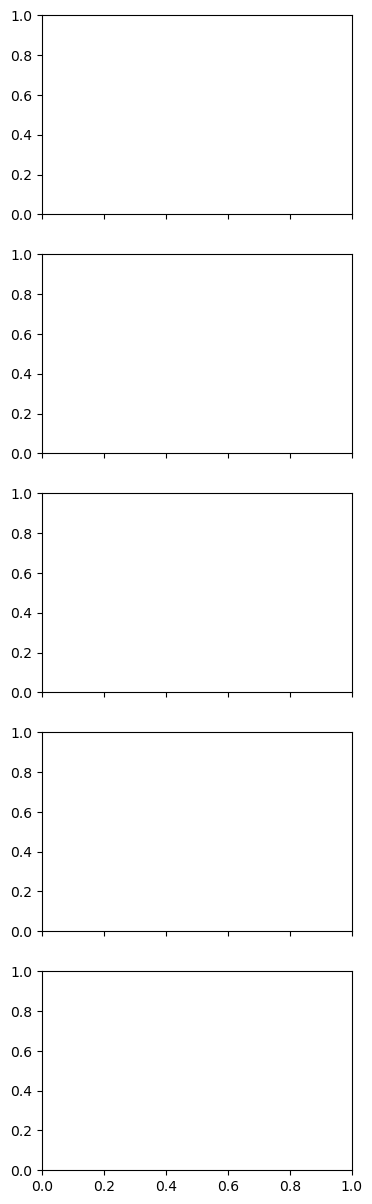

In [13]:
fig, axes = plt.subplots(5, 1, figsize=(4, 15), sharex=True, sharey=True)
axes = axes.ravel()

for ax, km in zip(axes, SCALES):
    ax.plot(centers_dict[km], H_no_mean_dict[km], lw=2, label="Simulation ζ/f")
    ax.plot(centers_dict[km], H_wi_mean_dict[km], lw=2, label="Extracted ζ/f")
    ax.plot(centers_dict[km], H_po_mean_dict[km], lw=2, label="Posterior ζ/f")
    ax.set_title(f"{km} km filtered")
    ax.axvline(0, color="k", ls="-", lw=1.0, alpha=0.7)
    ax.set_xlim(-2, 2)

# axis labels
axes[-1].set_xlabel("Geostrophic vorticity ζ/f")
for ax in axes:
    ax.set_ylabel("Probability density")

# legend only in first plot
axes[0].legend(
    loc="upper right",
    frameon=False,
    fontsize=9
)

fig.tight_layout()
plt.savefig("PDFS.pdf")
plt.show()

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# --- Compute variance, skewness, kurtosis from PDFs ---
scales = np.array(SCALES, dtype=float)
var_no, var_wi, var_po = [], [], []
skew_no, skew_wi, skew_po = [], [], []
kurt_no, kurt_wi, kurt_po = [], [], []

for km in SCALES:
    x = centers_dict[km]
    # normalized PDFs
    p_no = H_no_mean_dict[km] / np.trapz(H_no_mean_dict[km], x)
    p_wi = H_wi_mean_dict[km] / np.trapz(H_wi_mean_dict[km], x)
    p_po = H_po_mean_dict[km] / np.trapz(H_po_mean_dict[km], x)
    
    # expected values
    def pdf_moments(x, p):
        mean = np.trapz(x * p, x)
        var  = np.trapz((x - mean)**2 * p, x)
        sk   = np.trapz(((x - mean)**3 / var**1.5) * p, x)
        ku   = np.trapz(((x - mean)**4 / var**2) * p, x)
        return var, sk, ku

    v,s,k = pdf_moments(x, p_no); var_no.append(v); skew_no.append(s); kurt_no.append(k)
    v,s,k = pdf_moments(x, p_wi); var_wi.append(v); skew_wi.append(s); kurt_wi.append(k)
    v,s,k = pdf_moments(x, p_po); var_po.append(v); skew_po.append(s); kurt_po.append(k)

# --- Plot ---
fig, axes = plt.subplots(3, 1, figsize=(4, 8), sharex=True)
axes = axes.ravel()

# Variance
axes[0].plot(scales, var_no, "o-", label="Simulation")
axes[0].plot(scales, var_wi, "o-", label="Extracted")
axes[0].plot(scales, var_po, "o-", label="Posterior")
axes[0].set_ylabel("Variance")
axes[0].set_title("Variance")
axes[0].set_ylim(0, 0.4)

# Skewness
axes[1].plot(scales, skew_no, "o-")
axes[1].plot(scales, skew_wi, "o-")
axes[1].plot(scales, skew_po, "o-")
axes[1].set_ylabel("Skewness")
axes[1].set_title("Skewness")
axes[1].set_ylim(0, 1.5)

# Kurtosis
axes[2].plot(scales, kurt_no, "o-")
axes[2].plot(scales, kurt_wi, "o-")
axes[2].plot(scales, kurt_po, "o-")
axes[2].set_ylabel("Kurtosis")
axes[2].set_xlabel("Filter scale (km)")
axes[2].set_title("Kurtosis")
axes[2].set_ylim(2, 8)

tick_vals = [1, 2, 4, 8, 16]
for ax in axes:
    ax.set_xscale("log", base=2)
    ax.set_xticks(tick_vals)
    ax.set_xticklabels([str(v) for v in tick_vals])

axes[0].legend(frameon=False, ncol=1, loc="upper right")
fig.subplots_adjust(hspace=0.45)
plt.savefig("vort-moments.pdf")
plt.show()

KeyError: 32

NameError: name 'ht_1km_all' is not defined

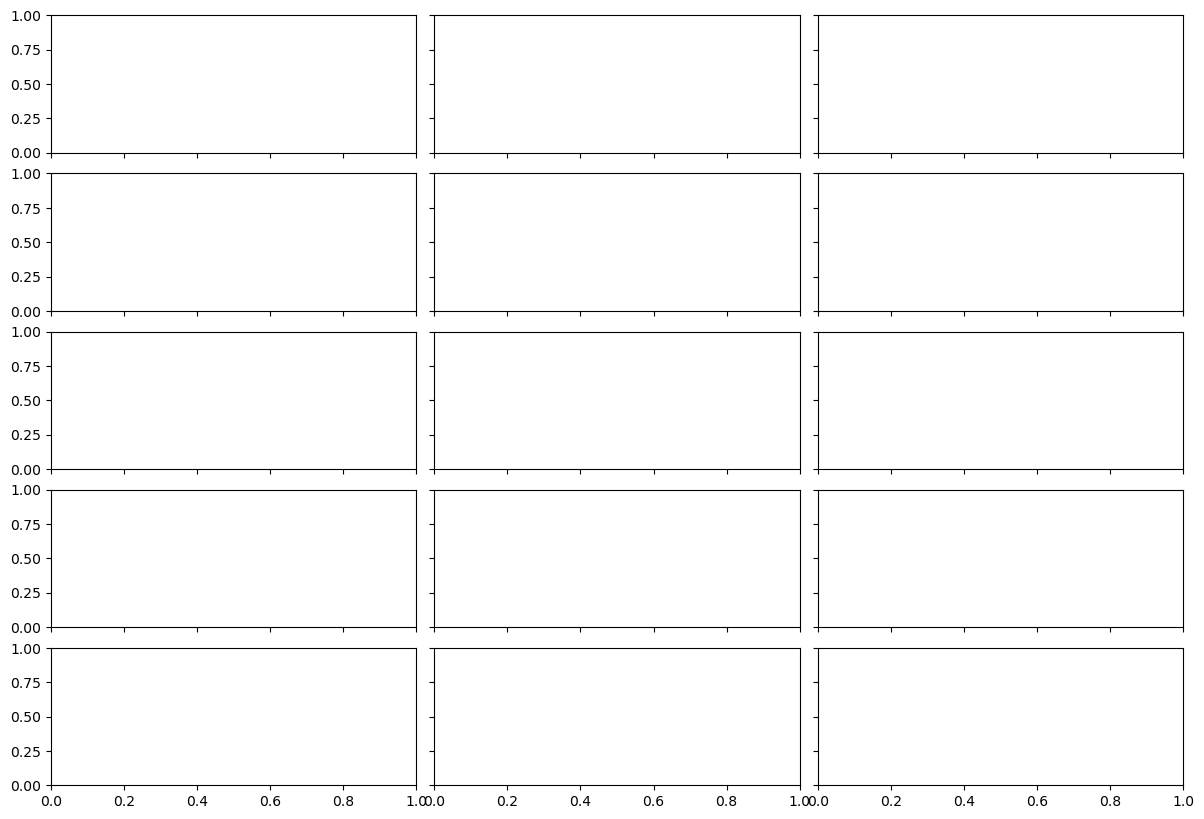

In [12]:
# ------------------
# Imshow panels of ζ/f for one time, across scales (Sim / Extracted / Posterior)
# ------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# choose a time index to display
t_show = 50
rng = np.random.default_rng(0)

def finite_sym_clim(arrs, q=99.0):
    """Symmetric vmin/vmax from percentile of absolute values across a list of arrays."""
    vals = np.concatenate([np.ravel(a[np.isfinite(a)]) for a in arrs])
    a = np.percentile(np.abs(vals), q)
    return (-a, a)


nrows = len(SCALES)
ncols = 3
fig, axes = plt.subplots(
    nrows, ncols, 
    figsize=(5*ncols, 2*nrows), 
    sharex=True, sharey=True,
    gridspec_kw={"wspace": 0.05, "hspace": 0.15, "right": 0.88}  #space for colorbars
)

if nrows == 1:
    axes = np.atleast_2d(axes)  # ensure 2D for uniform indexing

col_titles = ["Simulation ζ/f", "Extracted ζ/f", "Posterior ζ/f"]

for i, km in enumerate(SCALES):
    # load SSH fields already filtered to this scale
    ht_no_all = np.asarray(load(path_nonoise(km)), dtype=float)   # (T, y, x)
    ht_wi_all = np.asarray(load(path_withnoise(km)), dtype=float) # (T, y, x)
    ny, nx = ht_no_all.shape[1:]

    sy, sx = sigma_pixels(km, dx_m, dy_m)

    # --- Simulation and Extracted vorticity (ζ/f) at t_show ---
    z_sim = swot.compute_geostrophic_vorticity_5pt(ht_no_all[t_show], dx_m, dy_m, lat_1d)
    z_ext = swot.compute_geostrophic_vorticity_5pt(ht_wi_all[t_show], dx_m, dy_m, lat_1d)

    # --- Posterior sample at t_show: draw, smooth to this scale, then ζ/f ---
    mu_cm = ht_1km_all[t_show].ravel() * 100.0   # cm
    N = mu_cm.size
    z = rng.standard_normal(N)                   # one sample
    ssh_post = (mu_cm + (L @ z)) / 100.0         # meters
    ssh_post = ssh_post.reshape(ny, nx)
    ssh_post_smooth = gaussian_filter(ssh_post, sigma=(sy, sx), mode="reflect")
    z_post = swot.compute_geostrophic_vorticity_5pt(ssh_post_smooth, dx_m, dy_m, lat_1d)

    # symmetric color scale per row for fair comparison
    vmin, vmax = finite_sym_clim([z_sim, z_ext, z_post], q=99.0)

    # plot 3 columns
    ims = [
        axes[i, 0].imshow(z_sim.T, origin="lower", cmap="RdBu_r", vmin=vmin, vmax=vmax),
        axes[i, 1].imshow(z_ext.T, origin="lower", cmap="RdBu_r", vmin=vmin, vmax=vmax),
        axes[i, 2].imshow(z_post.T, origin="lower", cmap="RdBu_r", vmin=vmin, vmax=vmax),
    ]

    # titles and row label
    axes[i, 0].set_ylabel(f"{km} km", rotation=90)
    if i == 0:
        for j in range(ncols):
            axes[i, j].set_title(col_titles[j], fontsize=11)

    # add one colorbar per row (use the first image)
    cbar = fig.colorbar(ims[2], ax=axes[i, :], orientation="vertical", fraction=0.025, shrink = 0.5, pad=0.01)
    cbar.set_label("ζ / f", rotation=90)

# tidy
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle(f"ζ/f at t = {t_show}", y=0.995)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
